<a href="https://colab.research.google.com/github/salmenhsairi/EndOfStudiesProjectNotebooks/blob/main/trOCRDocTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TrOCR printed version Inference on Documents 
In this Notebook I'll apply trOCR to recognize text in the FUNSD dataset that contains noisy images so that we can take the text retrieval performance as a benchmark and for metric I chose CER which is  similar to Word Error Rate (WER) what jiwer library is used for. then I will evaluate the OCR with any uploaded image

In [ ]:
# setting up environment
! pip install transformers 
! pip install - q git+https: // github.com/huggingface/datasets.git "dill<0.3.5" jiwer
! sudo apt install tesseract-ocr
! sudo apt install libtesseract-dev

In [ ]:
# restart runtime after installing pytesseract
! pip install pytesseract

In [ ]:
from PIL import Image
from transformers import TrOCRProcessor , VisionEncoderDecoderModel
from datasets import load_dataset
from functools import cmp_to_key
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# loading the pre-procecessor and the model
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-stage1')
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
model.to(device)

## FUNSD testing

In [ ]:
# getting the data from hugging face hub
funsd_datasets = load_dataset("nielsr/funsd")
funst_train_set = funsd_datasets['train']

Reusing dataset funsd (/root/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/8b0472b536a2dcb975d59a4fb9d6fea4e6a1abe260b7fed6f75301e168cbe595)


  0%|          | 0/2 [00:00<?, ?it/s]

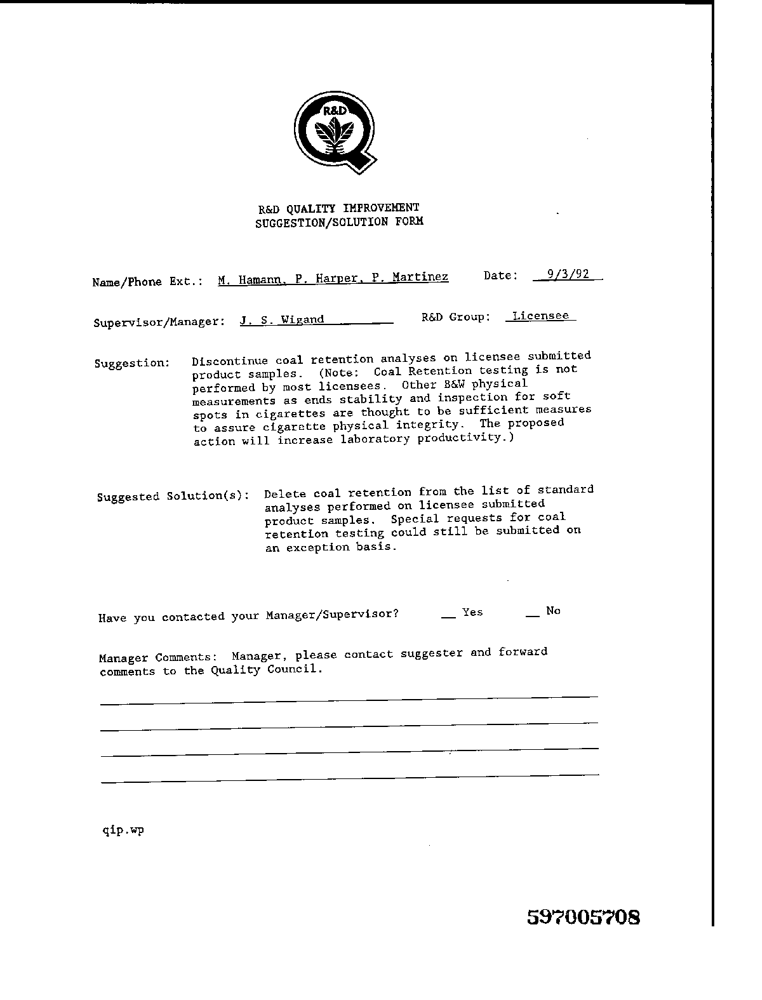

In [ ]:
# selecting and visualizing an image 
index = 0
path = funst_train_set[index]['image_path']
image = Image.open(path).convert("RGB")
image

In [ ]:
# Helper functions that operate on the bounding boxes
def unnormalize_box(bbox, width, height):
     return [
         int(width * (bbox[0] / 1000)),
         int(height * (bbox[1] / 1000)),
         int(width * (bbox[2] / 1000)),
         int(height * (bbox[3] / 1000)),
     ]

def compare_boxes(box2, box1):
  if (box2[1] - box1[1] > 10) or (box1[0] < box2[0] and abs(box2[1] - box1[1]) <= 10):
    return 1
  elif box1[1] == box2[1]:
    if box1[0] < box2[0]:
      return 1
    elif box1[0] == box2[0]:
      return 0
    else:
      return -1
  return -1

def get_image_rows(image_sorted_boxes):
  rows = ','.join([str(i) for i in image_sorted_boxes[0]])
  for i,box in enumerate(image_sorted_boxes[1:],start=1):
    if box[1] - image_sorted_boxes[i-1][1] <= 10:
      rows+= ' ' + ','.join([str(i) for i in box])
    else:
      rows+= '\n'
      rows+= ','.join([str(i) for i in box])
  return rows  

In [ ]:
image_object = funst_train_set[index]
image = Image.open(path).convert("RGB")
width, height = image.size
actual_boxes = [unnormalize_box((box),width,height) for box in image_object['bboxes']]

def sort_image_boxes(boxes):
  sorted_boxes = sorted(boxes, key=cmp_to_key(compare_boxes))
  return sorted_boxes

In [ ]:
# actual document text
sorted_boxes = sort_image_boxes(actual_boxes)
sorted_index = [actual_boxes.index(box) for box in sorted_boxes]
ground_truth_text = ' '.join([image_object['words'][k] for k in sorted_index])
ground_truth_text

'R&D R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. : M. Hamann P. Harper, P. Martinez Date: 9/ 3/ 92 Supervisor / Manager : J. S. Wigand R&D Group: Licensee Suggestion: Discontinue coal retention analyses on licensee submitted product samples (Note : Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spots in ciparettes are thought to be sufficient measures to assure cigarette physical integrity. The proposed action will increase laboratory productivity . ) Suggested Solutions (s) : Delete coal retention from the list of standard analyses performed on licensee submitted product samples. Special requests for coal retention testing could still be submitted on an exception basis. Have you contacted your Manager/ Supervisor? Yes No Manager Comments: Manager, please contact suggester and forward comments to the Quality Council. qip . wp 597005708'

In [ ]:
sorted_boxes = sort_image_boxes(actual_boxes)
_rows_sequence = get_image_rows(sorted_boxes)
rows = [[[int(x) for x in c.split(',')] for c in row.split()] for row in _rows_sequence.splitlines()]

# FUNSD contains images with a slight rotation, it may be useful to expand the text line shape
rows_edges = list()
for row in rows:
  line_x0 = min(row[0][0],row[-1][0])
  line_x1 = max(row[0][2],row[-1][2])
  line_y0 = min(row[0][1],row[-1][1])
  line_y1 = max(row[0][3],row[-1][3])
  rows_edges.append([line_x0,line_y0,line_x1,line_y1])

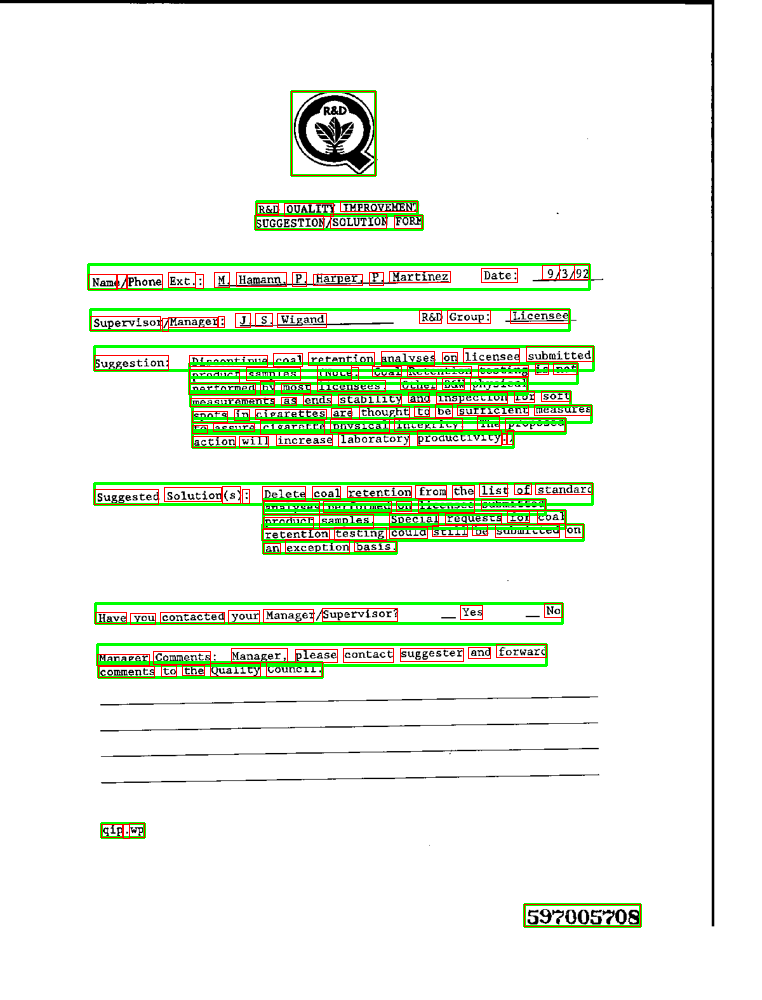

In [ ]:
from google.colab.patches import cv2_imshow
import pytesseract
from pytesseract import Output
import cv2
img = cv2.imread(path)
# d = pytesseract.image_to_data(img, output_type=Output.DICT)
n_boxes = len(rows_edges)
for i in range(n_boxes):
    (x0, y0, x1, y1) = (rows_edges[i][0], rows_edges[i][1], rows_edges[i][2], rows_edges[i][3])
    cv2.rectangle(img, (x0, y0), (x1, y1), (0, 255, 0), 2)
n_boxes_origin = len(sorted_boxes)
for i in range(n_boxes_origin):
    (x0, y0, x1, y1) = (sorted_boxes[i][0], sorted_boxes[i][1], sorted_boxes[i][2], sorted_boxes[i][3])
    cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 255), 1)
cv2_imshow(img)

In [ ]:
corped_lines = [image.crop((row[0],row[1],row[2],row[3])) for row in rows_edges]

In [ ]:
# here is an example of what a line looks like after croping the image
image.crop((258, 512, 570, 528))

In [ ]:
pixel_values = processor(corped_lines, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([22, 3, 384, 384])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


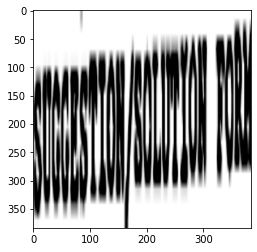

In [ ]:
#visualise the input image after preprocessing
import matplotlib.pyplot as plt
plt.imshow(pixel_values[2].squeeze().cpu().permute(1, 2, 0))

In [ ]:
#get the generated text
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)
output = " ".join(generated_text)
output

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'€ R&D QUALITY IMPROVEMENT SUGGESTION/SOLUTION FORM Name/Phone Ext. : M. Hamann, P. Harper, P. Martinez Date Supervisor/Manager: J. S. Wigand _ R&D Group: License Suggestion: Discontinue coal retention analyses on licensee submitted product samples. (Note: Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spots in cigarettes are thought to be sufficient measures to assure cigarette physical integrity. The proposed action will increase laboratory productivity. ) Suggested Solution(s): Delete coal retention from the list of standard analyses performed on licensee submitted product samples. Special requests for coal retention testing could still be submitted on an exception basis. Have you contacted your Manager/Supervisor? Yes _ No Manager Comments: Manager, please contact suggester and forward comments to the Quality Council. qip.wp 597005708'

In [ ]:
word_count_per_line = [len(line.split()) for line in generated_text]

In [ ]:
box_count_per_line = [len(line) for line in rows]

In [ ]:
generated_text

In [ ]:
assert(all([i==j for (i,j) in zip(word_count_per_line,box_count_per_line)]))

In [ ]:
from datasets import load_metric
cer_metric = load_metric("cer")
def get_metric(generated_text,ground_truth_text):
  pred_words_list = [word for line in generated_text for word in line.split()]
  actual_words_list = [word.upper() for word in ground_truth_text.split()]
  diff = abs(len(pred_words_list) - len(actual_words_list))
  if len(pred_words_list) > len(actual_words_list):
    actual_words_list.extend([' ' for k in range(diff)])
  elif len(pred_words_list) < len(actual_words_list):
    pred_words_list.extend([' ' for k in range(diff)])
  cer = cer_metric.compute(predictions=pred_words_list, references=actual_words_list)
  return cer

In [ ]:
get_metric(generated_text,ground_truth_text)

1.1748768472906403

## Custom image testing
At this point I will try to pass the image into the model  word by word by choosing Mode=WORD instead of line by line for maximum precision but the taken time could be not reasonable 
in all cases, the performance is highly dependent on the words detection


In [ ]:
# path = '/content/4d90a926-7b79-4457-800f-f6621b82dda7_2021-05-25_0805.txt_image_0.jpg'
path = '/content/1209sasugenovesidesignaout19_2021-06-05_1855.txt_image_0.jpg'
# path = '/content/1318 SAS VEGGIE MAGNIFIQUE 1ER TRIM 18 copy_2021-06-05_1855.txt_image_0.jpg'
# path = '/content/15a9d545-65df-4a88-a229-5f5653639882_2021-05-27_2109.txt_image_0.jpg'
# path = '/content/16_12uber59_2021-06-05_1854.txt_image_0.jpg'
image = Image.open(path).convert("RGB")
image

In [ ]:
#!/bin/bash          
path = path
! tesseract '$path' /content/tsv_output -l eng tsv

Tesseract Open Source OCR Engine v4.0.0-beta.1 with Leptonica
Warning. Invalid resolution 0 dpi. Using 70 instead.
Estimating resolution as 194


In [ ]:
import pandas as pd
ocr_df = pd.read_csv("/content/tsv_output.tsv", sep='\t')
ocr_df = ocr_df.dropna()
ocr_df = ocr_df.drop(ocr_df[ocr_df.text.str.strip() == ''].index)
tesseract_boxes = []
for index,row in ocr_df.iterrows():
  box = [row['left'],row['top'],row['left']+row['width'],row['top']+row['height']]
  tesseract_boxes.append(box)

In [ ]:
from enum import Enum
class Mode(Enum):
  LINE = 1
  WORD = 2
  # PAIR = 3

In [ ]:
chosen_mode = 'LINE'
sorted_boxes = sort_image_boxes(tesseract_boxes)
_rows_sequence = None

if chosen_mode == Mode.LINE.name:
  _rows_sequence = get_image_rows(sorted_boxes)
# elif chosen_mode == Mode.PAIR.name:
#   _rows_sequence = '\n'.join([f'{sorted_boxes[k][0]},{sorted_boxes[k][1]},{sorted_boxes[k][2]},{sorted_boxes[k][3]} {sorted_boxes[k+1][0]},{sorted_boxes[k+1][1]},{sorted_boxes[k+1][2]},{sorted_boxes[k+1][3]}'
#   for k in range(0,len(sorted_boxes)-1,2)])
elif chosen_mode == Mode.WORD.name:
  pass
  
if _rows_sequence != None:
  rows = [[[int(x) for x in c.split(',')] for c in row.split()] for row in _rows_sequence.splitlines()]
else:
  rows = [[box] for box in sorted_boxes]
rows_edges = list()
for row in rows:
  line_x0 = min(row[0][0],row[-1][0])
  line_x1 = max(row[0][2],row[-1][2])
  line_y0 = min(row[0][1],row[-1][1])
  line_y1 = max(row[0][3],row[-1][3])
  rows_edges.append([line_x0-12,line_y0-12,line_x1+12,line_y1+12])

In [ ]:
corped_lines = []
for row in rows_edges:
  try:
    chunk = image.crop((row[0],row[1],row[2],row[3]))
  except ValueError as error:
    if error == "Coordinate 'right' is less than 'left'":
      chunk = image.crop((row[2],row[1],row[0],row[3]))
    elif error == "Coordinate 'lower' is less than 'upper'":
      chunk = image.crop((row[0],row[3],row[2],row[1]))
  corped_lines.append(chunk)

In [ ]:
pixel_values = processor(corped_lines, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([26, 3, 384, 384])


In [ ]:
plt.imshow(pixel_values[0].squeeze().cpu().permute(1, 2, 0))

In [ ]:
from google.colab.patches import cv2_imshow
import pytesseract
from pytesseract import Output
import cv2
img = cv2.imread(path)
# d = pytesseract.image_to_data(img, output_type=Output.DICT)
n_boxes = len(rows_edges)
for i in range(n_boxes):
    (x0, y0, x1, y1) = (rows_edges[i][0], rows_edges[i][1], rows_edges[i][2], rows_edges[i][3])
    cv2.rectangle(img, (x0, y0), (x1, y1), (0, 255, 0), 2)
n_boxes_origin = len(sorted_boxes)
for i in range(n_boxes_origin):
    (x0, y0, x1, y1) = (sorted_boxes[i][0], sorted_boxes[i][1], sorted_boxes[i][2], sorted_boxes[i][3])
    cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 255), 2)

cv2_imshow(img)

In [ ]:
#get the generated text
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)
output = " ".join(generated_text)
output

In [ ]:
word_count_per_line = [len(line.split()) for line in generated_text]

In [ ]:
box_count_per_line = [len(line) for line in rows]

In [ ]:
assert(all([i==j for (i,j) in zip(word_count_per_line,box_count_per_line)]))

In [ ]:
generated_text